# Attention Baseline Code (step by step)

## import library

In [301]:
import os
import argparse
import multiprocessing
import numpy as np
import random
import time
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import yaml
import PIL
from tqdm import tqdm
from checkpoint import (
    default_checkpoint,
    load_checkpoint,
    save_checkpoint,
    init_tensorboard,
    write_tensorboard,
)
from psutil import virtual_memory

from flags import Flags
from utils import get_network, get_optimizer
from dataset import dataset_loader, START, PAD,load_vocab
from scheduler import CircularLRBeta

from metrics import word_error_rate,sentence_acc

## Argument Parsing

In [303]:
parser = argparse.ArgumentParser()
parser.add_argument(
        "-c",
        "--config_file",
        dest="config_file",
        default="configs/Attention.yaml",
        type=str,
        help="Path of configuration file",
    )
parser = parser.parse_args(args=[])

options = Flags(parser.config_file).get()

In [304]:
is_cuda = torch.cuda.is_available()
hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)

In [305]:
checkpoint = (
        load_checkpoint(options.checkpoint, cuda=is_cuda)
        if options.checkpoint != ""
        else default_checkpoint
    )
model_checkpoint = checkpoint["model"]

## Dataset

In [306]:
transformed = transforms.Compose(
        [
            # Resize so all images have the same size
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ])

train_data_loader, validation_data_loader, train_dataset, valid_dataset = dataset_loader(options, transformed)

In [307]:
print(len(train_dataset))
print(len(valid_dataset))

80000
20000


In [309]:
data_ex = next(iter(train_dataset))
print(data_ex)

{'path': '../input/data/train_dataset/images/train_62476.jpg', 'truth': {'text': '1 2 0 = 3 0 0 -', 'encoded': [0, 125, 177, 14, 180, 111, 14, 14, 214, 1]}, 'image': tensor([[[0.5765, 0.5451, 0.4902,  ..., 0.5804, 0.5765, 0.5725],
         [0.5804, 0.5294, 0.4510,  ..., 0.5804, 0.5765, 0.5765],
         [0.5765, 0.5176, 0.4039,  ..., 0.5725, 0.5765, 0.5725],
         ...,
         [0.5176, 0.5098, 0.5176,  ..., 0.5765, 0.5765, 0.5804],
         [0.4941, 0.4902, 0.4941,  ..., 0.5804, 0.5843, 0.5843],
         [0.4588, 0.4588, 0.4627,  ..., 0.5765, 0.5765, 0.5765]],

        [[0.5451, 0.5098, 0.4588,  ..., 0.5490, 0.5451, 0.5412],
         [0.5490, 0.4980, 0.4196,  ..., 0.5490, 0.5451, 0.5451],
         [0.5451, 0.4863, 0.3725,  ..., 0.5451, 0.5451, 0.5412],
         ...,
         [0.4980, 0.4863, 0.4902,  ..., 0.5529, 0.5529, 0.5569],
         [0.4627, 0.4588, 0.4627,  ..., 0.5490, 0.5529, 0.5569],
         [0.4275, 0.4275, 0.4314,  ..., 0.5451, 0.5451, 0.5451]],

        [[0.5333, 0.50

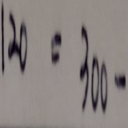

In [310]:
tf = transforms.ToPILImage()
image = tf(data_ex['image'])
image

In [311]:
print(data_ex['truth']['text'])
print(len(data_ex['truth']['text'].split()))

1 2 0 = 3 0 0 -
8


In [312]:
print(data_ex['truth']['encoded'])
print(len(data_ex['truth']['encoded']))

[0, 125, 177, 14, 180, 111, 14, 14, 214, 1]
10


## Learning process

### 1. Data load

In [313]:
data = next(iter(train_data_loader))
input = data["image"].cuda()
expected = data["truth"]["encoded"].cuda()

In [321]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))

torch.Size([1, 3, 128, 128])
['i \\times \\left( i \\times j \\right) = i \\times k = - j']
14


In [319]:
print(expected)
print(len(expected[0]))

tensor([[  0, 130, 199, 229, 130, 199,  87, 137, 180, 130, 199, 169, 180, 214,
          87,   1]], device='cuda:0')
16


In [322]:
expected[expected == -1] = train_data_loader.dataset.token_to_id[PAD]

### 2. Network load

In [323]:
model = get_network(
        options.network,
        options,
        model_checkpoint,
        device,
        train_dataset,
    )
model.cuda()
model.train()

Attention(
  (encoder): CNN(
    (conv0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu0): ReLU(inplace=True)
    )
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Sequential(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
    )
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU(inplace=True)
    )
    (pooling3): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=F

In [324]:
model._modules.keys()

odict_keys(['encoder', 'decoder', 'criterion'])

## 3. Forward path

In [326]:
output = model(input, expected, True, 1)

In [327]:
print(output)
print(output.shape)

tensor([[[-0.0047,  0.0214, -0.0293,  ...,  0.0471,  0.1442, -0.1092],
         [ 0.0348, -0.0907,  0.0161,  ...,  0.0021,  0.0987, -0.1614],
         [-0.1384,  0.0376,  0.0264,  ..., -0.1363,  0.1685, -0.0284],
         ...,
         [-0.0486, -0.0197,  0.1072,  ...,  0.0183,  0.1424, -0.0794],
         [ 0.0646, -0.0916, -0.0379,  ...,  0.0753,  0.0709,  0.0716],
         [-0.1602, -0.0189, -0.1951,  ..., -0.0038,  0.1068,  0.0080]]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 15, 245])


### 4. Loss calculate

In [325]:
criterion = model.criterion.to(device)

In [328]:
decoded_values = output.transpose(1, 2)
print(decoded_values.shape)

torch.Size([1, 245, 15])


In [333]:
_, sequence = torch.topk(decoded_values, 1, dim=1)
print(sequence)
print(len(sequence[0][0]))

tensor([[[118, 118, 110,  47, 118, 110, 196, 110, 196, 118, 196, 238,  33,  99,
          196]]], device='cuda:0')
15


In [330]:
print(sequence.shape)
sequence = sequence.squeeze(1)
print(sequence.shape)

torch.Size([1, 1, 15])
torch.Size([1, 15])


In [334]:
print(len(expected[:,1:][0]))
print(decoded_values.shape)

15
torch.Size([1, 245, 15])


In [336]:
loss = criterion(decoded_values, expected[:, 1:])
print(loss)

tensor(5.5247, device='cuda:0', grad_fn=<NllLoss2DBackward>)


### 5. Evaulate

In [337]:
def id_to_string(tokens, data_loader,do_eval=0):
    result = []
    if do_eval:
        special_ids = [data_loader.dataset.token_to_id["<PAD>"], data_loader.dataset.token_to_id["<SOS>"],
                       data_loader.dataset.token_to_id["<EOS>"]]

    for example in tokens:
        string = ""
        if do_eval:
            for token in example:
                token = token.item()
                if token not in special_ids:
                    if token != -1:
                        string += data_loader.dataset.id_to_token[token] + " "
        else:
            for token in example:
                token = token.item()
                if token != -1:
                    string += data_loader.dataset.id_to_token[token] + " "

        result.append(string)
    return result

In [338]:
correct_symbols = 0
total_symbols = 0
wer=0
num_wer=0
sent_acc=0
num_sent_acc=0

In [339]:
expected[expected == train_data_loader.dataset.token_to_id[PAD]] = -1

In [340]:
expected_str = id_to_string(expected, train_data_loader,do_eval=1)

In [341]:
expected_str

['i \\times \\left( i \\times j \\right) = i \\times k = - j ']

In [345]:
sequence_str = id_to_string(sequence[0], train_data_loader,do_eval=1)

In [346]:
sequence_str

['\\nexists \\nexists \\xi \\wedge \\nexists \\xi \\overline \\xi \\overline \\nexists \\overline \\otimes \\theta y \\overline ']

#### Word Error rate

In [347]:
import editdistance
import numpy as np

In [348]:
sum_wer=0.0
for output,ground_truth in zip(sequence_str,expected_str):
		output=output.split(" ")
		ground_truth=ground_truth.split(" ")
		distance = editdistance.eval(output, ground_truth)
		length = max(len(output),len(ground_truth))
		sum_wer+=(distance/length)
wer = sum_wer

In [349]:
wer

0.9375

#### Sentence Accuracy

In [350]:
correct_sentences=0
for output,ground_truth in zip(sequence_str,expected_str):
	if np.array_equal(output,ground_truth):
		correct_sentences+=1
sent_acc = correct_sentences

In [351]:
sent_acc

0

#### Correct/Total symbol

In [353]:
correct_symbols += torch.sum(sequence[0] == expected[:, 1:], dim=(0, 1)).item()

In [354]:
correct_symbols

0

In [355]:
total_symbols += torch.sum(expected[:, 1:] != -1, dim=(0, 1)).item()

In [356]:
total_symbols

15

## Network (Encoder / Decoder)

In [357]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random

from dataset import START, PAD
from networks.Attention import CNN, AttentionCell, AttentionDecoder

### 1. Data

In [358]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))

torch.Size([1, 3, 128, 128])
['i \\times \\left( i \\times j \\right) = i \\times k = - j']
14


In [359]:
print(expected)
print(len(expected[0]))

tensor([[  0, 130, 199, 229, 130, 199,  87, 137, 180, 130, 199, 169, 180, 214,
          87,   1]], device='cuda:0')
16


### 2. Attention Network

In [360]:
FLAGS = options
train_dataset = train_dataset
checkpoint = None

In [361]:
encoder = CNN(FLAGS.data.rgb)

In [362]:
encoder.cuda()

CNN(
  (conv0): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
  )
  (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
  )
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
  )
  (pooling3): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (conv4): Conv2d(256, 512, kerne

In [363]:
decoder = AttentionDecoder(
            num_classes=len(train_dataset.id_to_token),
            src_dim=FLAGS.Attention.src_dim,
            embedding_dim=FLAGS.Attention.embedding_dim,
            hidden_dim=FLAGS.Attention.hidden_dim,
            pad_id=train_dataset.token_to_id[PAD],
            st_id=train_dataset.token_to_id[START],
            num_layers=FLAGS.Attention.layer_num,
            cell_type=FLAGS.Attention.cell_type)

In [364]:
decoder.cuda()

AttentionDecoder(
  (embedding): Embedding(246, 128)
  (attention_cell): AttentionCell(
    (i2h): Linear(in_features=512, out_features=128, bias=False)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
    (score): Linear(in_features=128, out_features=1, bias=False)
    (rnn): LSTMCell(640, 128)
  )
  (generator): Linear(in_features=128, out_features=245, bias=True)
)

In [365]:
criterion = (nn.CrossEntropyLoss())

### 3. Forward Path

In [366]:
out = encoder(input)
print(out.shape)

torch.Size([1, 512, 7, 33])


In [367]:
b, c, h, w = out.size()
out = out.view(b, c, h * w).transpose(1, 2)
print(out.shape)

torch.Size([1, 231, 512])


In [368]:
output = decoder(out, expected, 'train', 1, batch_max_length=expected.size(1))
print(output.shape)

torch.Size([1, 15, 245])


## Network (AttentionDecoder)

### 1. Data

In [373]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))
print(expected)
print(len(expected[0]))

torch.Size([1, 3, 128, 128])
['i \\times \\left( i \\times j \\right) = i \\times k = - j']
14
tensor([[  0, 130, 199, 229, 130, 199,  87, 137, 180, 130, 199, 169, 180, 214,
          87,   1]], device='cuda:0')
16


### 2. Encoder

In [374]:
out = encoder(input)
print(out.shape)
b, c, h, w = out.size()
out = out.view(b, c, h * w).transpose(1, 2)  # [b, h x w, c]
print(out.shape)

torch.Size([1, 512, 7, 33])
torch.Size([1, 231, 512])


### 3. AttentionDecoder

In [375]:
num_classes = len(train_dataset.id_to_token)
src_dim = FLAGS.Attention.src_dim
embedding_dim =FLAGS.Attention.embedding_dim
hidden_dim =FLAGS.Attention.hidden_dim
pad_id = train_dataset.token_to_id[PAD]
st_id = train_dataset.token_to_id[START]
num_layers=1
cell_type='LSTM'
checkpoint=None

In [376]:
embedding = nn.Embedding(num_classes + 1, embedding_dim)

In [377]:
embedding.cuda()

Embedding(246, 128)

In [378]:
attention_cell = AttentionCell(
            src_dim, hidden_dim, embedding_dim, num_layers, cell_type
        )

In [379]:
attention_cell.cuda()

AttentionCell(
  (i2h): Linear(in_features=512, out_features=128, bias=False)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (score): Linear(in_features=128, out_features=1, bias=False)
  (rnn): LSTMCell(640, 128)
)

In [380]:
generator = nn.Linear(hidden_dim, num_classes)

In [381]:
generator.cuda()

Linear(in_features=128, out_features=245, bias=True)

### 4. Forward Path

In [382]:
src = out
print(src.shape)
text = expected
print(text[0].shape)
is_train = True
teacher_forcing_ratio=1.0
batch_max_length = expected.size(1)

torch.Size([1, 231, 512])
torch.Size([16])


In [383]:
batch_size = src.size(0)
num_steps = batch_max_length - 1 

In [384]:
output_hiddens = (
            torch.FloatTensor(batch_size, num_steps, hidden_dim)
            .fill_(0)
            .to(device)
        )

In [385]:
output_hiddens.shape

torch.Size([1, 15, 128])

In [386]:
if num_layers == 1:
            hidden = (
                torch.FloatTensor(batch_size, hidden_dim).fill_(0).to(device),
                torch.FloatTensor(batch_size, hidden_dim).fill_(0).to(device),
            )

In [387]:
hidden[0].shape

torch.Size([1, 128])

In [389]:
if is_train and random.random() <= teacher_forcing_ratio:
    for i in range(num_steps):
        # one-hot vectors for a i-th char. in a batch
        embedd = embedding(text[:, i])
        # hidden : decoder's hidden s_{t-1}, batch_H : encoder's hidden H, char_onehots : one-hot(y_{t-1})
        hidden, alpha = attention_cell(hidden, src, embedd)
        if num_layers == 1:
            output_hiddens[:, i, :] = hidden[0]  # LSTM hidden index (0: hidden, 1: Cell)
        else:
            output_hiddens[:, i, :] = hidden[-1][0]
    
    print(embedd.shape)
    print(hidden[0].shape)
    print(alpha.shape)
    
    probs = generator(output_hiddens)
    print(probs.shape)

torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 231, 1])
torch.Size([1, 15, 245])


## Network (AttentionCell)

In [390]:
src_dim = src_dim
hidden_dim = hidden_dim
embedding_dim = embedding_dim
num_layers = 1
cell_type = 'LSTM'

### 1. Data

In [391]:
embedd = embedding(text[:, 0])
print(embedd.shape)

torch.Size([1, 128])


In [392]:
print(hidden[0].shape)
print(src.shape)

torch.Size([1, 128])
torch.Size([1, 231, 512])


### 2. Weight

In [393]:
i2h = nn.Linear(src_dim, hidden_dim, bias=False)

In [394]:
i2h.cuda()

Linear(in_features=512, out_features=128, bias=False)

In [395]:
h2h = nn.Linear(hidden_dim, hidden_dim)

In [396]:
h2h.cuda()

Linear(in_features=128, out_features=128, bias=True)

In [397]:
score = nn.Linear(hidden_dim, 1, bias=False)

In [398]:
score.cuda()

Linear(in_features=128, out_features=1, bias=False)

In [399]:
if num_layers == 1:
    if cell_type == 'LSTM':
        rnn = nn.LSTMCell(src_dim + embedding_dim, hidden_dim)

In [400]:
rnn.cuda()

LSTMCell(640, 128)

### 3. Forward path

In [401]:
src_features = i2h(src)
print(src_features.shape)

torch.Size([1, 231, 128])


In [402]:
prev_hidden_proj = h2h(hidden[0]).unsqueeze(1)
print(prev_hidden_proj.shape)

torch.Size([1, 1, 128])


In [403]:
attention_logit = score(torch.tanh(src_features + prev_hidden_proj)) 
print(attention_logit.shape)

torch.Size([1, 231, 1])


In [404]:
alpha = F.softmax(attention_logit, dim=1)
print(alpha.shape)

torch.Size([1, 231, 1])


In [405]:
print(alpha.permute(0, 2, 1).shape)
print(src.shape)
context = torch.bmm(alpha.permute(0, 2, 1), src).squeeze(1)
print(context.shape)

torch.Size([1, 1, 231])
torch.Size([1, 231, 512])
torch.Size([1, 512])


In [406]:
print(embedd.shape)
concat_context = torch.cat([context, embedd], 1)
print(concat_context.shape)

torch.Size([1, 128])
torch.Size([1, 640])


In [407]:
cur_hidden = rnn(concat_context, hidden)
print(cur_hidden[0].shape)

torch.Size([1, 128])
